##1. Problem 
Identifying diseases given cassava images

##2. Data 
provided by Kaggle

##3. Evaluation 
to share in the provided format as the sample_submission.csv

##4. Features
We have 21,397 images in the training set 

Basic EDA 

In [49]:
import os
from glob import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread 
%matplotlib inline
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras


In [50]:
files = glob('../input/cassava-leaf-disease-classification/*.csv')
for f in files:
    df = pd.read_csv(f, nrows=5)
    display(f,df.head())

'../input/cassava-leaf-disease-classification/sample_submission.csv'

,image_id,label
0,2216849948.jpg,4


'../input/cassava-leaf-disease-classification/train.csv'

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [51]:
train = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
#train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


In [52]:
disease_map = open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json')
json = json.load(disease_map)
json

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [53]:
for i in range (len(train)):
    if train['label'][i] == 0:
        train.replace(to_replace = train['label'][i],
                     value = 'Cassava Bacterial Blight (CBB)', inplace=True)
    elif train['label'][i] == 1:
        train.replace(to_replace = train['label'][i],
                     value = 'Cassava Brown Streak Disease (CBSD)', inplace=True)
    elif train['label'][i] == 2:
        train.replace(to_replace = train['label'][i],
                     value = 'Cassava Green Mottle (CGM)', inplace = True)
    elif train['label'][i]== 3:
        train.replace(to_replace = train['label'][i],
                     value = 'Cassava Mosaic Disease (CMD)', inplace = True)
    elif train['label'][i]== 4:
        train.replace(to_replace = train['label'][i],
                      value = 'Healthy', inplace = True)

In [54]:
train.head()

,image_id,label
0,1000015157.jpg,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,Cassava Mosaic Disease (CMD)
2,100042118.jpg,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,Cassava Mosaic Disease (CMD)


## Preprocessing

<AxesSubplot:>

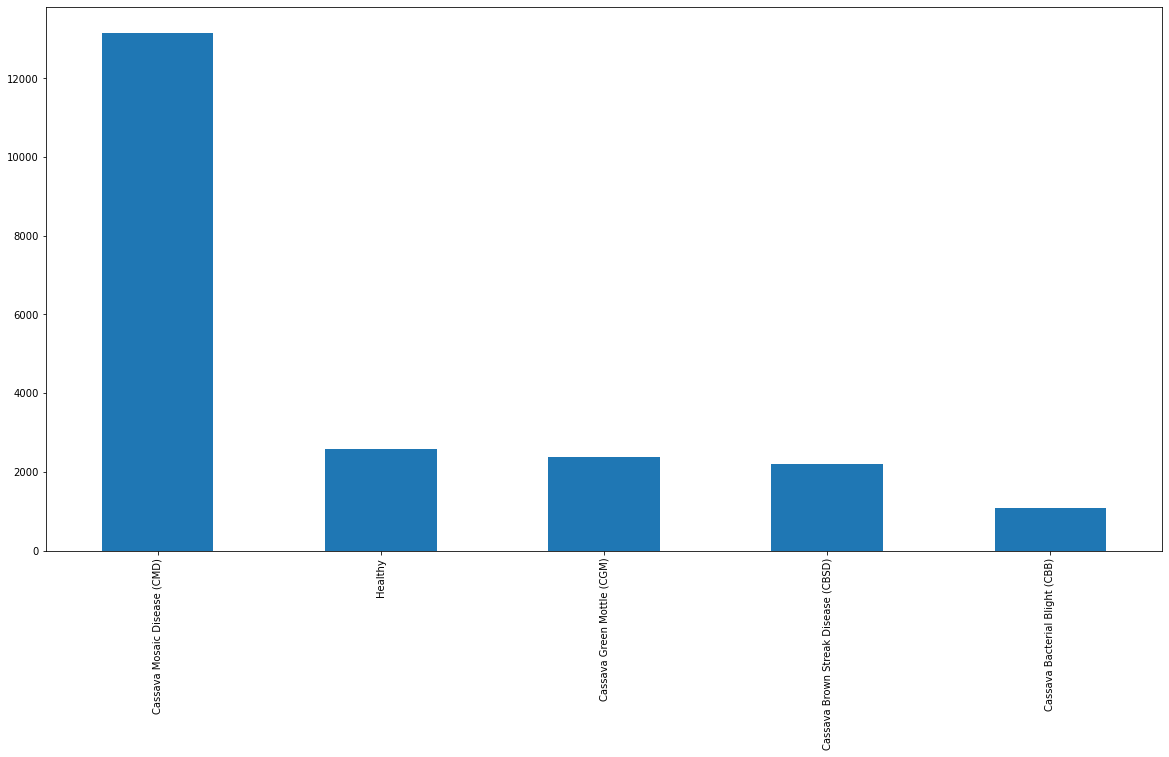

In [55]:
train["label"].value_counts().plot.bar(figsize=(20,10))

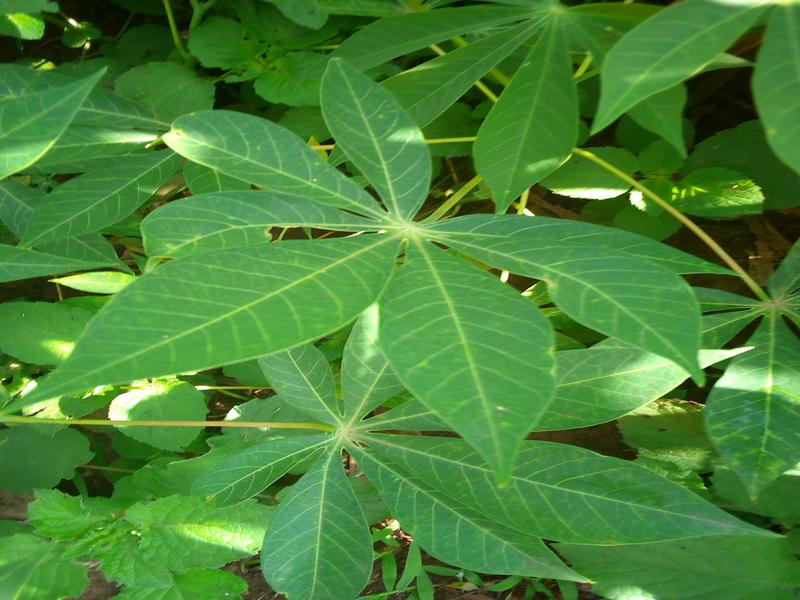

In [56]:
from IPython.display import Image
Image("../input/cassava-leaf-disease-classification/train_images/100042118.jpg")

## Organizing Images and their labels

In [57]:
filenames = ["../input/cassava-leaf-disease-classification/train_images/"+ fname for  fname in train["image_id"]]

filenames[:10]

['../input/cassava-leaf-disease-classification/train_images/1000015157.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1000201771.jpg',
 '../input/cassava-leaf-disease-classification/train_images/100042118.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1000723321.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1000812911.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1000837476.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1000910826.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1001320321.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1001723730.jpg',
 '../input/cassava-leaf-disease-classification/train_images/1001742395.jpg']

In [58]:
labels = train["label"].to_numpy()
labels

array(['Cassava Bacterial Blight (CBB)', 'Cassava Mosaic Disease (CMD)',
       'Cassava Brown Streak Disease (CBSD)', ...,
       'Cassava Brown Streak Disease (CBSD)', 'Healthy', 'Healthy'],
      dtype=object)

In [59]:
unique_labels = np.unique(labels)
unique_labels

array(['Cassava Bacterial Blight (CBB)',
       'Cassava Brown Streak Disease (CBSD)',
       'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)',
       'Healthy'], dtype=object)

In [60]:
boolean_labels = [label == unique_labels for label in labels]
boolean_labels[:2]

[array([ True, False, False, False, False]),
 array([False, False, False,  True, False])]

## Validation Set

In [61]:
X = filenames
y = boolean_labels

In [62]:
NUM_IMAGES = 1000
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],  
                                                  
                                                 y[:NUM_IMAGES],  
                                                 test_size=0.2,
                                                 random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

## Preprocessing Images

In [63]:
IMG_SIZE = 224


def process_image(image_path, img_size=IMG_SIZE):

  image = tf.io.read_file(image_path)
  
  image = tf.image.decode_jpeg(image, channels=3)
  
  image = tf.image.convert_image_dtype(image, tf.float32)
  
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Batching

In [64]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [65]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):

  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) 
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

 
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  
                                               tf.constant(y))) 
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    data = data.shuffle(buffer_size=len(X)) 

    data = data.map(get_image_label)

    data_batch = data.batch(BATCH_SIZE)
    return data_batch

In [66]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

In [67]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[6.23899579e-01, 3.72018844e-01, 3.17567050e-01],
          [4.52701122e-01, 3.14245701e-01, 2.36394569e-01],
          [4.62284952e-01, 3.40126038e-01, 2.71638662e-01],
          ...,
          [2.34513894e-01, 2.38435462e-01, 2.18827620e-01],
          [1.83964014e-01, 1.71259150e-01, 1.44278258e-01],
          [1.71018437e-01, 1.32362843e-01, 1.06592596e-01]],
 
         [[4.99920011e-01, 2.81772733e-01, 2.28571445e-01],
          [5.90726316e-01, 3.93277317e-01, 3.38925600e-01],
          [7.21428633e-01, 4.92226928e-01, 4.54831958e-01],
          ...,
          [8.60949159e-02, 7.27794543e-02, 5.99343479e-02],
          [1.54330224e-01, 1.34722382e-01, 1.11192964e-01],
          [2.79031724e-01, 2.38135323e-01, 2.17547104e-01]],
 
         [[5.24199724e-01, 3.56402576e-01, 3.13455403e-01],
          [7.41726756e-01, 4.71638680e-01, 4.44057643e-01],
          [8.82703125e-01, 5.36624670e-01, 5.23949623e-01],
          ...,
          [2.79751778e-01, 2.47718945e-01, 2.3628

## Building the model

In [68]:
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

OUTPUT_SHAPE = len(unique_labels)

MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [69]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), 
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") 
  ])

  
  model.compile(
      loss=keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  
  model.build(INPUT_SHAPE)

  return model

In [70]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 5010      
Total params: 5,437,723
Trainable params: 5,010
Non-trainable params: 5,432,713
_________________________________________________________________


## Callbacks

In [71]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [72]:
def train_model():
  
  model = create_model()
  
  model.fit(x=train_data,
            epochs=10,
            validation_data=val_data,
            validation_freq=1,  
            callbacks=[early_stopping])
  
  return model

In [73]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/10
25/25 [==============================] - 11s 309ms/step - loss: 1.6029 - accuracy: 0.5100 - val_loss: 1.1616 - val_accuracy: 0.5900
Epoch 2/10
25/25 [==============================] - 7s 270ms/step - loss: 0.9253 - accuracy: 0.6784 - val_loss: 1.0228 - val_accuracy: 0.6300
Epoch 3/10
25/25 [==============================] - 7s 277ms/step - loss: 0.7487 - accuracy: 0.7334 - val_loss: 0.9865 - val_accuracy: 0.6750
Epoch 4/10
25/25 [==============================] - 7s 271ms/step - loss: 0.6148 - accuracy: 0.7941 - val_loss: 0.9717 - val_accuracy: 0.6650
Epoch 5/10
25/25 [==============================] - 7s 293ms/step - loss: 0.6187 - accuracy: 0.7838 - val_loss: 0.9961 - val_accuracy: 0.6400
Epoch 6/10
25/25 [==============================] - 7s 278ms/step - loss: 0.5263 - accuracy: 0.8182 - val_loss: 0.9810 - val_accuracy: 0.6800
Epoch 7/10
25/25 [==============================] - 7s

In [74]:
val_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>

In [75]:
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 2s 184ms/step


array([[1.37499403e-02, 4.41029757e-01, 3.13585089e-03, 5.30556679e-01,
        1.15277600e-02],
       [3.82254912e-05, 1.09267440e-02, 5.81587851e-03, 9.83218074e-01,
        1.04457081e-06],
       [1.78717636e-03, 5.21711782e-02, 2.12648883e-02, 9.11761582e-01,
        1.30151212e-02],
       [2.71364897e-01, 5.09337783e-01, 5.31881675e-03, 2.32093763e-02,
        1.90769106e-01],
       [4.55039693e-03, 1.15131848e-02, 3.13506350e-02, 9.31688488e-01,
        2.08973158e-02],
       [3.45494882e-05, 4.46147373e-04, 7.20316693e-02, 9.27239597e-01,
        2.48079683e-04],
       [1.94100896e-03, 9.34084691e-03, 1.28072454e-03, 9.86145616e-01,
        1.29181240e-03],
       [2.45291600e-03, 3.29803601e-02, 7.85679296e-02, 8.79658759e-01,
        6.34002965e-03],
       [4.63583589e-01, 2.65292466e-01, 4.08050983e-04, 1.23201869e-04,
        2.70592719e-01],
       [3.96946562e-04, 8.20055790e-03, 4.10778401e-03, 9.81616855e-01,
        5.67787979e-03],
       [1.91611081e-01, 1.2714

In [76]:
def get_pred_label(prediction_probabilities):
  
  return unique_labels[np.argmax(prediction_probabilities)]


pred_label = get_pred_label(predictions[91])
pred_label

'Healthy'

In [77]:
def unbatchify(data):
  
  images =[]
  labels =[]
  
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])

  return images, labels

val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.7166567 , 0.6559424 , 0.50237095],
         [0.75857353, 0.68453383, 0.5286115 ],
         [0.6684774 , 0.5822029 , 0.4292617 ],
         ...,
         [0.14887977, 0.25084054, 0.00517201],
         [0.13858557, 0.20697318, 0.0141957 ],
         [0.18582416, 0.23960571, 0.05081008]],
 
        [[0.862345  , 0.8171669 , 0.69863945],
         [0.9461285 , 0.8882754 , 0.7459184 ],
         [0.61212486, 0.5362845 , 0.3532713 ],
         ...,
         [0.17090854, 0.27455008, 0.01670665],
         [0.14446847, 0.22085911, 0.01049454],
         [0.19455823, 0.25721323, 0.05896393]],
 
        [[0.80008006, 0.76547617, 0.62156856],
         [0.64925975, 0.59348744, 0.41352543],
         [0.6242197 , 0.53502405, 0.2872849 ],
         ...,
         [0.19089657, 0.29710907, 0.02128858],
         [0.14916022, 0.24327788, 0.00855364],
         [0.15173095, 0.23474415, 0.0162567 ]],
 
        ...,
 
        [[0.2920069 , 0.1569929 , 0.03038224],
         [0.25892353, 0.14005603, 0.02881

In [78]:
model.evaluate(val_data)

7/7 [==============================] - 1s 182ms/step - loss: 0.9904 - accuracy: 0.6650


[0.9904080033302307, 0.6650000214576721]

## Train the model on full data

In [79]:
len(X), len(y)

(21397, 21397)

In [80]:
full_data = create_data_batches(X,y)
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>

In [81]:
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [82]:
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3) 

In [83]:
full_model.fit(x=full_data,
               epochs=10,
               callbacks=[full_model_early_stopping])

Epoch 1/10
669/669 [==============================] - 150s 221ms/step - loss: 0.9324 - accuracy: 0.6770
Epoch 2/10
669/669 [==============================] - 146s 219ms/step - loss: 0.7017 - accuracy: 0.7450
Epoch 3/10
669/669 [==============================] - 148s 221ms/step - loss: 0.6772 - accuracy: 0.7549
Epoch 4/10
669/669 [==============================] - 147s 219ms/step - loss: 0.6478 - accuracy: 0.7632
Epoch 5/10
669/669 [==============================] - 147s 219ms/step - loss: 0.6691 - accuracy: 0.7609
Epoch 6/10
669/669 [==============================] - 147s 220ms/step - loss: 0.6456 - accuracy: 0.7691
Epoch 7/10
669/669 [==============================] - 147s 219ms/step - loss: 0.6539 - accuracy: 0.7648
Epoch 8/10
669/669 [==============================] - 148s 221ms/step - loss: 0.6480 - accuracy: 0.7626
Epoch 9/10
669/669 [==============================] - 148s 221ms/step - loss: 0.6301 - accuracy: 0.7688
Epoch 10/10
669/669 [==============================] - 147s 220m

In [84]:
model.save('Cassava_Leaf_model_2.h5')

In [85]:
keras = tf.keras
from tensorflow.keras.models import model_from_json
import tensorflow_hub as hub

In [86]:
loaded_full_model = keras.models.load_model("Cassava_Leaf_model_2.h5",custom_objects={'KerasLayer': hub.KerasLayer})
loaded_full_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_4 (KerasLayer)   (None, 1001)              5432713   
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5010      
Total params: 5,437,723
Trainable params: 5,010
Non-trainable params: 5,432,713
_________________________________________________________________


In [87]:
test_path = "../input/cassava-leaf-disease-classification/test_images/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['../input/cassava-leaf-disease-classification/test_images/2216849948.jpg']

In [88]:
test_data = create_data_batches(test_filenames, test_data=True)

In [89]:
test_predictions = loaded_full_model.predict(test_data, 
                                             verbose=1)

1/1 [==============================] - 0s 462ms/step


In [90]:
np.savetxt("./preds_array.csv", test_predictions, delimiter=",")

In [91]:
test_predictions = np.loadtxt("./preds_array.csv", delimiter=",")

In [92]:
test_predictions[:10]

array([0.00203597, 0.01260272, 0.15135963, 0.80135244, 0.03264917])

In [93]:
test_predictions.shape

(5,)

## Submission Dataset

In [94]:
IMG_SIZE = 224
preds = []
ss = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False)

In [95]:
my_submission

,image_id,label
0,2216849948.jpg,2
